# Binary Classification with a Software Defects Dataset
Playground Series - Season 3, Episode 23
https://www.kaggle.com/competitions/playground-series-s3e23/data

In [52]:
# Libraries
import numpy as np
import pandas as pd

from preprocessing import read_train, SMOTE_data, plot_dist

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

### Data

In [2]:
X, y = read_train()
X, y = SMOTE_data(X, y)

In [3]:
from collections import Counter
(counter := Counter(y))

Counter({False: 59023, True: 39349})

In [4]:
# As discover in the EDA, we will log transform all X for better distribution
log_X = np.log(X + .001)

In [5]:
# Transform data into Standard scale
ss = StandardScaler()
fit_X = ss.fit_transform(log_X)

In [6]:
def transform_X(X):
    ss = StandardScaler()
    return ss.fit_transform(np.log(X + .001))

In [7]:
# Since we already balanced out the classes
xtrain, xtest, ytrain, ytest = train_test_split(fit_X, y, test_size=.3)

### Network

In [33]:
# Create dataset object
class DefectDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.astype(int).values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [34]:
train_ds = DefectDataset(xtrain, ytrain)
test_ds = DefectDataset(xtest, ytest)

In [35]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

In [11]:
# Check data
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 21])
Labels batch shape: torch.Size([64])


In [12]:
train_features

tensor([[ 0.1414,  0.4189,  0.5054,  ...,  0.3613,  0.3678,  0.4740],
        [ 0.1744,  0.7338, -0.6652,  ...,  0.4013,  0.3387,  0.7587],
        [-1.0033, -0.7835, -0.6652,  ...,  0.0494, -0.0502, -0.7185],
        ...,
        [-1.2184, -0.7835, -0.6652,  ...,  0.0320, -0.3052, -0.7185],
        [-0.7448, -0.3398,  0.5054,  ...,  0.0816, -0.0171, -0.2497],
        [-0.6708, -0.7835, -0.6652,  ...,  0.1732,  0.1498, -0.7185]])

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [36]:
class DefectNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(21, 64)
        self.relu = nn.ReLU()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 16),
            nn.Tanh()
        )
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.relu(x)
        x = self.linear_tanh_stack(x)
        x = self.output(x)
        logits = self.sigmoid(x)

        return logits

In [37]:
model = DefectNetwork()

In [38]:
model(train_features).data

tensor([[0.4719],
        [0.4707],
        [0.4769],
        [0.4744],
        [0.4793],
        [0.5296],
        [0.4771],
        [0.4711],
        [0.4655],
        [0.4711],
        [0.4691],
        [0.4640],
        [0.4616],
        [0.4740],
        [0.4733],
        [0.4681],
        [0.4709],
        [0.4691],
        [0.4808],
        [0.4603],
        [0.4704],
        [0.4647],
        [0.4768],
        [0.4745],
        [0.4580],
        [0.4610],
        [0.4812],
        [0.4651],
        [0.5285],
        [0.4742],
        [0.4737],
        [0.5316],
        [0.4670],
        [0.4712],
        [0.4680],
        [0.4736],
        [0.4758],
        [0.5286],
        [0.4777],
        [0.5310],
        [0.4737],
        [0.4753],
        [0.4716],
        [0.4616],
        [0.4681],
        [0.4668],
        [0.5284],
        [0.4706],
        [0.4796],
        [0.5243],
        [0.4617],
        [0.4772],
        [0.4697],
        [0.5295],
        [0.4811],
        [0

### Training

In [39]:
# Loss and batch size
# Consider implement own loss function for better ROC performance
loss_fn = nn.BCELoss()
batch_size_train = 64

In [83]:
def test(model, loader, roc=False):
    """Test a network model on the test data.
    
    model: a `nn.Module` object representing the neural network to test
    loader: a `DataLoader` object containing the testing data, potentially in batches
    
    Returns a tuple (test_loss, accuracy), where test_loss is the average loss on the
    test data, and accuracy is the accuracy rate (out of 100%) of the predictions.
    """
    
    # Put the network in evaluation mode
    model.eval()
    
    test_loss = 0
    roc_scores = []
    
    # don't track gradients during this calculation
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            target = target.unsqueeze(1)
            
            # calculate the loss on this batch
            test_loss += loss_fn(output, target)
            if roc:
                pred = output.detach().numpy()
                roc_scores.append(roc_auc_score(target, pred))

    # get the overall loss across all batches
    test_loss /= len(loader.dataset)
    
    return test_loss, np.mean(roc_scores) if roc else test_loss

In [84]:
def train(model, optimizer, train_loader, test_loader, n_epochs=5, log_interval=50, verbose=False):
    """Train a network model with a particular optimizer.
    
    model: a `nn.Module` object representing the neural network to train
    optimizer: a PyTorch optimizer, such as SGD
    train_loader: a `DataLoader` object containing the training data, potentially in batches
    test_loader: the same, but for the testing data
    n_epochs: number of epochs of training to run
    log_interval: after how many batches should record our progress?
    verbose: print the progress after each log_interval steps?
    
    Returns a tuple (train_losses, counter, test_losses). train_losses is a list of 
    losses after every log_interval training steps; train_counter is a list giving the number
    of training observations seen by the training process by each of those steps; test_losses
    gives the test-set loss before each epoch and after the final epoch; test_counter gives
    the number of training observations seen at each epoch.
    """
    
    # Storage
    train_losses = []
    test_losses = []
    train_counter = []
    test_counter = []
    
    samples_seen = 0
    
    for epoch in range(n_epochs):
        # test at the beginning of each epoch
        test_loss = test(model, test_loader)
        test_losses.append(test_loss)
        test_counter.append(samples_seen)
        
        model.train() # put the network in training mode

        for batch_idx, (data, target) in enumerate(train_loader):
            # Reset all gradients
            optimizer.zero_grad()
    
            # Obtain the model's predictions with the data
            predictions = model(data)
            target = target.unsqueeze(1)
    
            # Get the loss, using the known Ys
            loss = loss_fn(predictions, target)
    
            # Calculate the gradients with backpropagation
            loss.backward()
    
            # Perform one gradient descent step
            optimizer.step()

            # Count how much data we've seen
            samples_seen += batch_size_train
            
            # Every log_interval steps, print out the progress
            if batch_idx % log_interval == 0:
                if verbose:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader), loss.item()))
                
                train_losses.append(loss.item())
                train_counter.append(samples_seen)
                

    # test after the final epoch
    test_loss, test_roc_score = test(model, test_loader, roc=True)
    test_losses.append(test_loss)
    test_counter.append(samples_seen)
                
    return train_losses, train_counter, test_losses, test_counter, test_roc_score

In [50]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [85]:
target = train_labels.detach().numpy()
pred = model(train_features).detach().numpy()

In [75]:
roc_auc_score([int(pre) for pre in pred >= .5], target)

0.8227272727272728

In [86]:
train_losses, train_counter, test_losses, test_counter, test_accuracies = train(
        model, optimizer, train_dl, test_dl, n_epochs=10, verbose=True
    )

Train Epoch: 1 [0/68860 (0%)]	Loss: 0.465743
Train Epoch: 1 [3200/68860 (5%)]	Loss: 0.594630
Train Epoch: 1 [6400/68860 (9%)]	Loss: 0.523879
Train Epoch: 1 [9600/68860 (14%)]	Loss: 0.545121
Train Epoch: 1 [12800/68860 (19%)]	Loss: 0.655089
Train Epoch: 1 [16000/68860 (23%)]	Loss: 0.441925
Train Epoch: 1 [19200/68860 (28%)]	Loss: 0.555573
Train Epoch: 1 [22400/68860 (33%)]	Loss: 0.578710
Train Epoch: 1 [25600/68860 (37%)]	Loss: 0.537760
Train Epoch: 1 [28800/68860 (42%)]	Loss: 0.456978
Train Epoch: 1 [32000/68860 (46%)]	Loss: 0.588563
Train Epoch: 1 [35200/68860 (51%)]	Loss: 0.546258
Train Epoch: 1 [38400/68860 (56%)]	Loss: 0.438518
Train Epoch: 1 [41600/68860 (60%)]	Loss: 0.498471
Train Epoch: 1 [44800/68860 (65%)]	Loss: 0.448678
Train Epoch: 1 [48000/68860 (70%)]	Loss: 0.576747
Train Epoch: 1 [51200/68860 (74%)]	Loss: 0.597457
Train Epoch: 1 [54400/68860 (79%)]	Loss: 0.655599
Train Epoch: 1 [57600/68860 (84%)]	Loss: 0.613943
Train Epoch: 1 [60800/68860 (88%)]	Loss: 0.573816
Train Epoc

In [47]:
counter = Counter(ytrain)
counter

Counter({False: 41229, True: 27631})

Final test loss: tensor(0.0085)
Final test accuracies: tensor(60.2941)


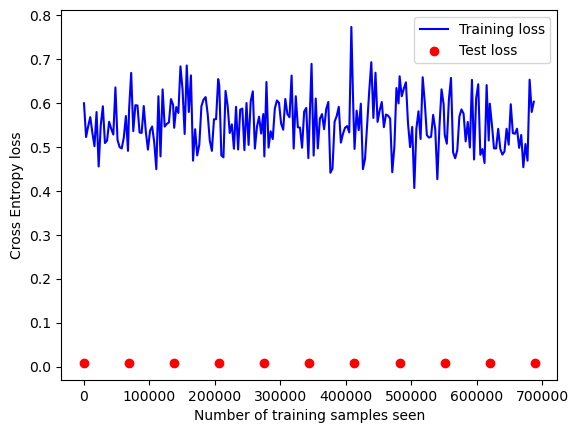

In [53]:
print("Final test loss:", test_losses[-1])
print("Final test accuracies:", test_accuracies[-1])

plt.plot(train_counter, train_losses, color="blue")
plt.scatter(test_counter, test_losses, color="red")
plt.legend(["Training loss", "Test loss"], loc="upper right")
plt.xlabel("Number of training samples seen")
plt.ylabel("Cross Entropy loss")
plt.show()